In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
%matplotlib inline

In [2]:
DATA_PATH = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [3]:
covid_data = pd.read_csv(DATA_PATH)

In [4]:
# Let's drop aggregated data like OWID*
OWID_index = covid_data.loc[covid_data['iso_code'].str.contains('OWID')].index

covid_data = covid_data.drop(OWID_index)

Построение описывающей модели, дамми-переменные для стран и периода после начала вакцинации, нормировка и регуляризация.


ex_mort = 
b0 + 
b1 * country_dummy + 
b2 * num_sick + 
b3 * time + 
b4 * dummy_date_vacc + 
(b5 * time*dummy_date_vacc) +
...

In [5]:
covid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [6]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [7]:
covid_data = covid_data.loc[(covid_data['date'] < '2022-11-01')]

<AxesSubplot: xlabel='date', ylabel='new_deaths_smoothed_per_million'>

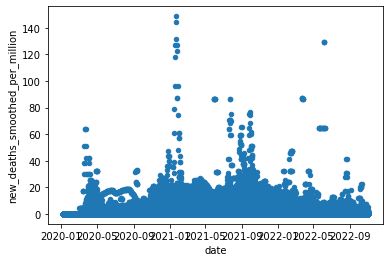

In [8]:
covid_data.plot.scatter(x='date',y='new_deaths_smoothed_per_million')

<AxesSubplot: >

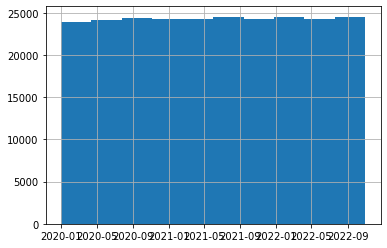

In [9]:
covid_data['date'].hist()

In [10]:
country_dummies = pd.get_dummies(covid_data['iso_code'])

In [11]:
country_dummies.head()

,ABW,AFG,AGO,AIA,ALB,AND,ARE,ARG,ARM,ASM,...,VGB,VIR,VNM,VUT,WLF,WSM,YEM,ZAF,ZMB,ZWE
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
covid_data[country_dummies.columns] = country_dummies

<ipython-input-12-2b96580c1e84>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data[country_dummies.columns] = country_dummies
<ipython-input-12-2b96580c1e84>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data[country_dummies.columns] = country_dummies
<ipython-input-12-2b96580c1e84>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [13]:
# Fill NaN forward:

for country in covid_data['iso_code'].unique():

    temp = covid_data.loc[covid_data['iso_code'] == country, 'people_vaccinated_per_hundred'].copy()
    temp.fillna(method = 'ffill', inplace=True)
    covid_data.loc[covid_data['iso_code'] == country, 'people_vaccinated_per_hundred'] = temp



<AxesSubplot: xlabel='date', ylabel='people_vaccinated_per_hundred'>

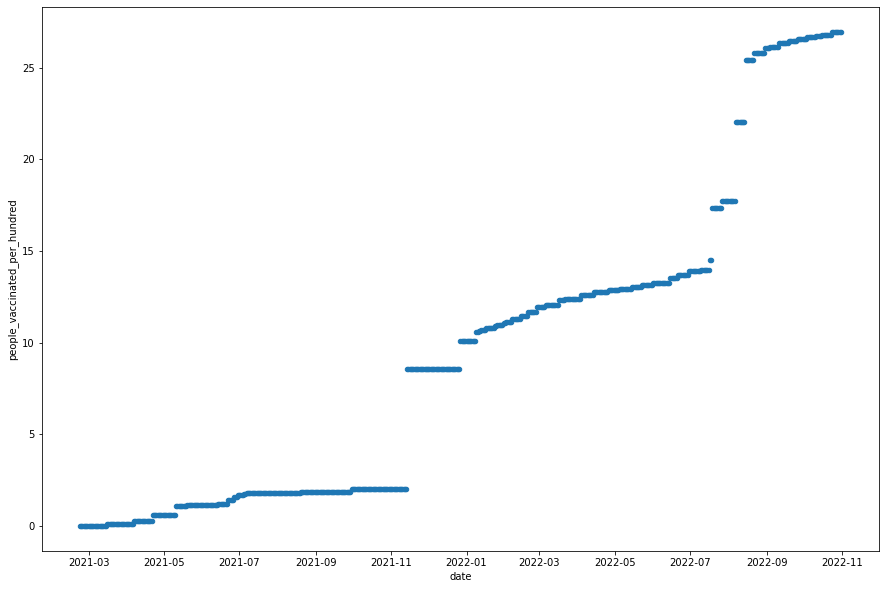

In [14]:
# Let's see... it works!

country = covid_data.loc[covid_data['iso_code'] == 'AFG']

country.plot(kind='scatter',x='date',y='people_vaccinated_per_hundred', figsize=(15,10))

In [15]:
# Here is the correction for NaN, should be zeros:

covid_data['people_vaccinated_per_hundred'].fillna(0, inplace=True)


In [16]:
# Check it's non-decreasing

for country in covid_data['iso_code'].unique():
    vec_to_check = \
    covid_data.loc[covid_data['iso_code'] == country, 'people_vaccinated_per_hundred'] - \
    covid_data.loc[covid_data['iso_code'] == country, 'people_vaccinated_per_hundred'].shift(1)

    if any(vec_to_check<0):
        print(country)
        print(vec_to_check.loc[vec_to_check < 0])

In [17]:
covid_data['people_vaccinated_per_hundred'].describe()

count    243350.000000
mean         23.597520
std          31.088834
min           0.000000
25%           0.000000
50%           1.330000
75%          49.400000
max         128.760000
Name: people_vaccinated_per_hundred, dtype: float64

In [18]:
# Период после 1% вакцинированных, можно играться с порогом

covid_data['vax_period'] = (covid_data['people_vaccinated_per_hundred'] > 1).astype(int)

<ipython-input-18-a5d431d1acf7>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['vax_period'] = (covid_data['people_vaccinated_per_hundred'] > 1).astype(int)


In [19]:
# Сколько прошло дней в штуках с начала наблюдений для страны

for country in covid_data['iso_code'].unique():
    min_country_date = covid_data.loc[covid_data['iso_code'] == country, 'date'].min()
    covid_data.loc[covid_data['iso_code'] == country, 'day_0_covid_country'] = min_country_date

covid_data['days_covid'] = (covid_data['date'] - covid_data['day_0_covid_country']).dt.days

<ipython-input-19-3bdf4ad91294>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data.loc[covid_data['iso_code'] == country, 'day_0_covid_country'] = min_country_date
<ipython-input-19-3bdf4ad91294>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['days_covid'] = (covid_data['date'] - covid_data['day_0_covid_country']).dt.days


In [20]:
# Сколько новых кейсов Ковид (нормировка на 1 млн населения), дамми для периода после вакцинации

covid_data['v_new_cases_per_million'] = covid_data['new_cases_per_million'] * covid_data['vax_period']

<ipython-input-20-4f6e9184f58e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['v_new_cases_per_million'] = covid_data['new_cases_per_million'] * covid_data['vax_period']


In [21]:
# Дни после начала на дамми для периода после вакцинации

# covid_data['v_days_covid'] = covid_data['days_covid'] * covid_data['vax_period']

In [22]:
# Дамми для года

covid_data['year'] = covid_data['date'].dt.year

year = pd.get_dummies(covid_data['year'])

<ipython-input-22-25d105e3604d>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['year'] = covid_data['date'].dt.year


In [23]:
year

,2020,2021,2022
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
348212,False,False,True
348213,False,False,True
348214,False,False,True
348215,False,False,True


In [24]:
covid_data[['2020','2021','2022']] = year[[2020,2021,2022]]

<ipython-input-24-1088d2a239fa>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data[['2020','2021','2022']] = year[[2020,2021,2022]]
<ipython-input-24-1088d2a239fa>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data[['2020','2021','2022']] = year[[2020,2021,2022]]
<ipython-input-24-1088d2a239fa>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [25]:
# Immunity for the share of people 30 days after vaccination

from datetime import timedelta

covid_data['vac_30'] = 0

for i, country in enumerate(covid_data['iso_code'].unique()):
    
#     if i == 1:
#         break
    
    country_data = covid_data.loc[covid_data['iso_code'] == country, \
                                  ['date','people_vaccinated_per_hundred']].copy()
      
    country_data['date2'] = country_data['date'] + timedelta(days=30) 
    

    temp = country_data.set_index('date').join(\
        country_data.set_index('date2'), rsuffix='r')
    
    temp = temp['people_vaccinated_per_hundredr'].values #.fillna(0).values
    
    covid_data.loc[covid_data['iso_code'] == country, \
                                'vac_30'] = \
                                temp


<ipython-input-25-7ec33d6f4489>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['vac_30'] = 0


In [26]:
# stringency_index for the share of people 14 days after it is calculated

from datetime import timedelta

covid_data['si_14'] = 0

for i, country in enumerate(covid_data['iso_code'].unique()):
    
#     if i == 1:
#         break
    
    country_data = covid_data.loc[covid_data['iso_code'] == country, \
                                  ['date','stringency_index']].copy()
      
    country_data['date2'] = country_data['date'] + timedelta(days=14) 
    

    temp = country_data.set_index('date').join(\
        country_data.set_index('date2'), rsuffix='r')
    
    temp = temp['stringency_indexr'].values #.fillna(0).values
    
    covid_data.loc[covid_data['iso_code'] == country, \
                                'si_14'] = \
                                temp

<ipython-input-26-19a78f82ab92>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covid_data['si_14'] = 0


0 RUS


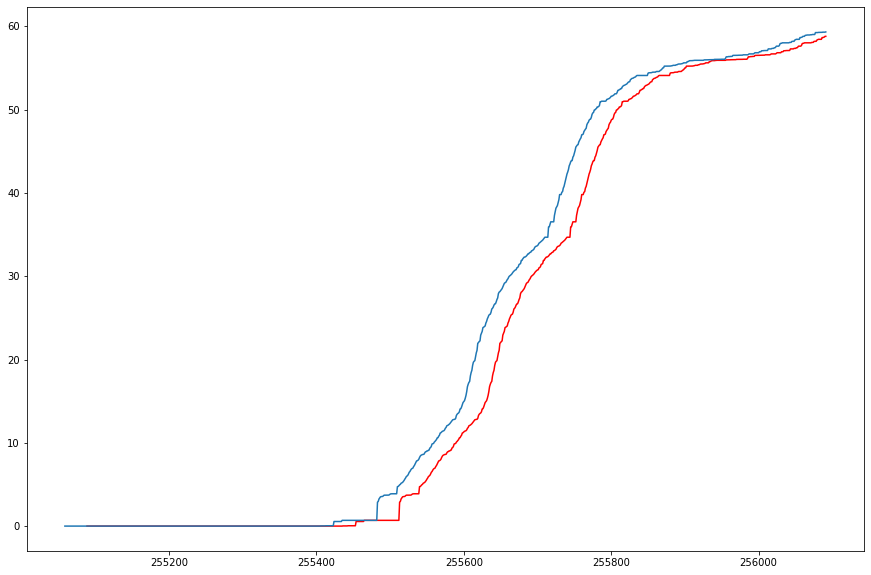

In [27]:
for i, country in enumerate([['RUS']]):#pd.DataFrame(covid_data['iso_code'].unique()).sample(10).values):
    print(i, country[0])
    covid_data.loc[covid_data['iso_code'] == country[0], 'vac_30'].plot(figsize=(15,10), c='red')
    covid_data.loc[covid_data['iso_code'] == country[0], 'people_vaccinated_per_hundred'].plot(figsize=(15,10))


0 RUS


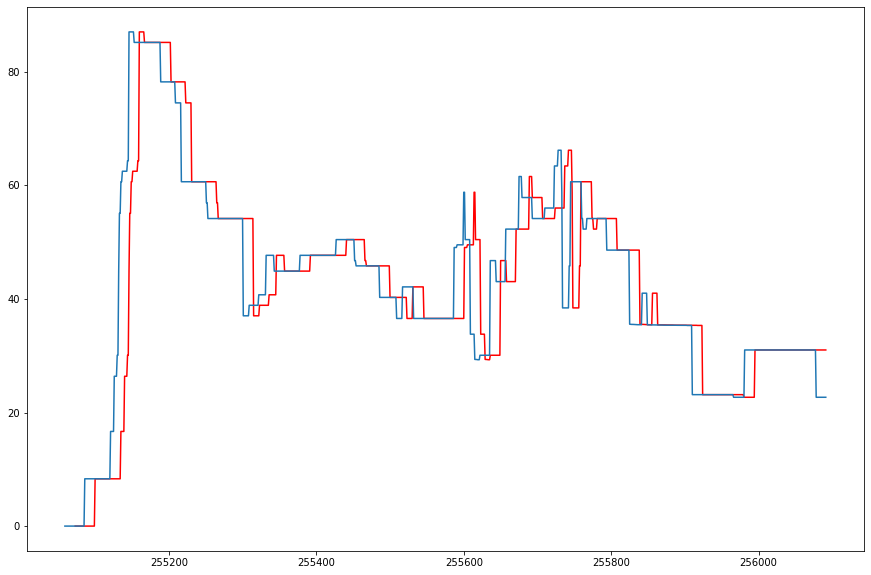

In [28]:
for i, country in enumerate([['RUS']]):#pd.DataFrame(covid_data['iso_code'].unique()).sample(10).values):
    print(i, country[0])
    covid_data.loc[covid_data['iso_code'] == country[0], 'si_14'].plot(figsize=(15,10), c='red')
    covid_data.loc[covid_data['iso_code'] == country[0], 'stringency_index'].plot(figsize=(15,10))

In [29]:
# Choose only countries with deaths in 2020 > 1000

temp = covid_data.groupby(['iso_code', '2020'])['new_deaths'].sum().reset_index()

temp = temp.loc[(temp['2020'] == 1) & (temp['new_deaths'] > 1000), 'iso_code']

country_1K = list(temp.values)

covid_data_1K = covid_data.loc[covid_data['iso_code'].isin(country_1K)].copy()

In [30]:
data = covid_data_1K[
        country_1K +
        ['2020', '2021', '2022'] +
        [
        'vax_period',
        'days_covid',
#        'v_days_covid',
#        'stringency_index',
        'si_14',
#        'v_stringency',
        'new_cases_per_million',
#        'v_new_cases_per_million',
#        'people_vaccinated_per_hundred',
        'vac_30',
        'aged_65_older',
        'new_deaths',
#    'excess_mortality'
]]

In [31]:
data = data.dropna()

X = data.iloc[:,:-1] # Take y out

y = data['new_deaths']

C:\Users\komarov\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='x', ylabel='y'>

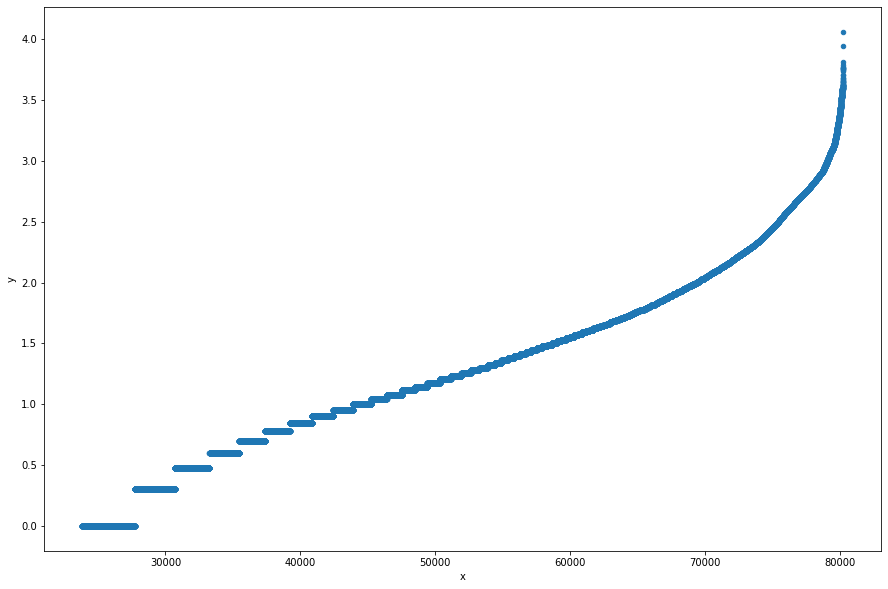

In [32]:
# Лестница в небеса

sorted_death = pd.DataFrame(sorted(y))
sorted_death['x'] = sorted_death.index
sorted_death['y'] = np.log10(sorted_death[0]); del sorted_death[0]

sorted_death.plot.scatter(figsize=(15,10), x='x', y='y')

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [34]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [36]:
X.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape

((80228, 92), (60171, 92), (20057, 92), (60171,), (20057,))

In [37]:
# Train, normalized above

reg_train = linear_model.Ridge(alpha=1, random_state=1)

reg_train.fit(X_train_scaled, y_train.values)

Ridge(alpha=1, random_state=1)

In [38]:
from eli5 import show_weights

show_weights(reg_train, feature_names=X_train.columns.tolist())

Weight?,Feature
+106.649,USA
+76.068,<BIAS>
+69.384,BRA
+49.376,IND
+46.669,new_cases_per_million
+34.372,RUS
+29.825,MEX
+28.640,days_covid
+25.564,si_14
+21.889,vax_period


In [39]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg_train, random_state=1).fit(X_val_scaled, y_val.values)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.3269 ± 0.0115,USA
0.1199 ± 0.0033,BRA
0.0980 ± 0.0027,vac_30
0.0662 ± 0.0013,IND
0.0480 ± 0.0019,new_cases_per_million
0.0268 ± 0.0012,RUS
0.0222 ± 0.0014,MEX
0.0176 ± 0.0008,days_covid
0.0173 ± 0.0013,si_14
0.0113 ± 0.0014,vax_period


In [40]:
print(list(X.columns).index('USA'))
idx = X_val.iloc[:,80] == 1

80


In [41]:
y_pred = reg_train.predict(X_val_scaled[idx,:])
y_pred[y_pred<0] = 0

In [42]:
usa = pd.DataFrame(X_val.loc[idx, 'days_covid'])
usa['true'] = y_val.values[idx]
usa['pred'] = y_pred

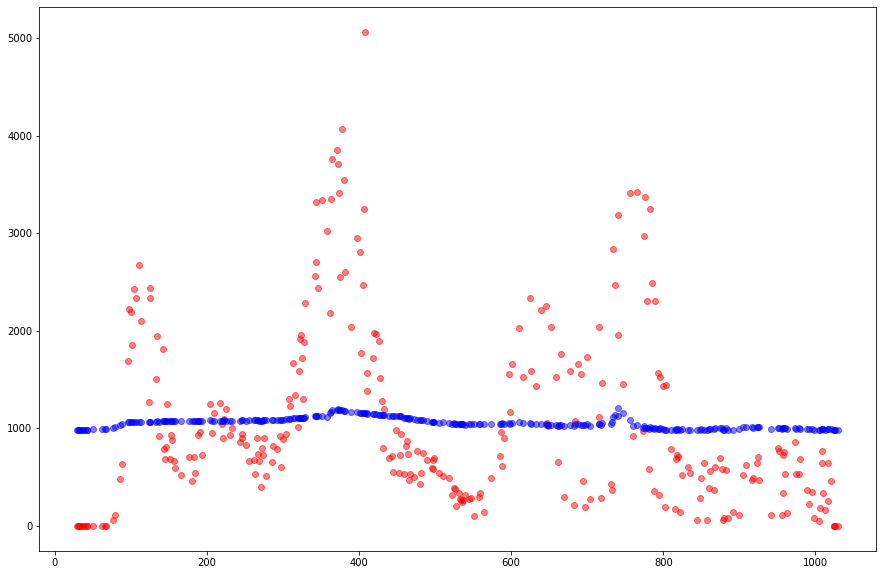

In [43]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=usa['days_covid'], y=usa['true'], alpha=0.5, c='red')
plt.scatter(x=usa['days_covid'], y=usa['pred'], alpha=0.5, c='blue')

plt.show()

In [44]:
# y_pred_all = reg_train.predict(X_val_scaled)
# y_pred_all[y_pred_all<0] = 0

# all = pd.DataFrame(X_val['days_covid'])
# all['true'] = y_val.values
# all['pred'] = y_pred_all

# figure(figsize=(15, 10))
# plt.scatter(x=all['days_covid'], y=all['true'], alpha=0.5, c='red')
# plt.scatter(x=all['days_covid'], y=all['pred'], alpha=0.5, c='blue')
# plt.show()

In [45]:
# MAE on USA

from sklearn.metrics import median_absolute_error

mae = median_absolute_error(usa['true'], usa['pred'])
string_score = f"MAE on dataset: {mae:.2f}"
print (string_score)

MAE on dataset: 570.52


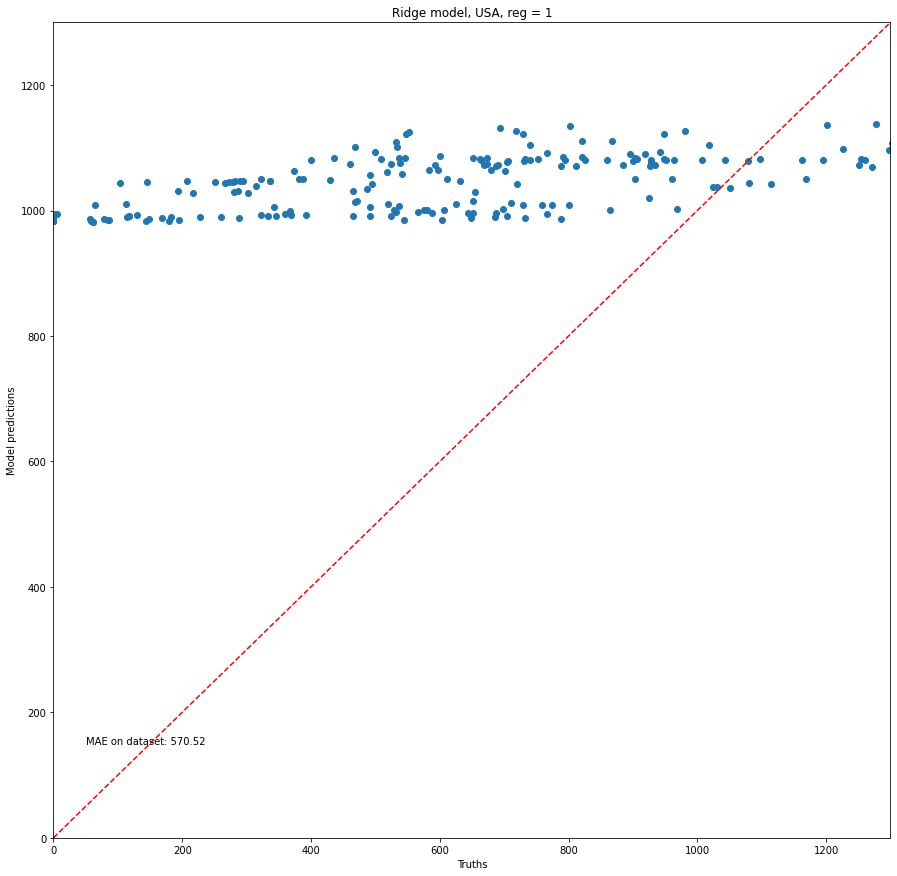

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(usa["true"], usa["pred"])
ax.plot([0, 2000], [0, 2000], transform=ax.transAxes, ls="--", c="red")
plt.text(50, 150, string_score)
plt.title("Ridge model, USA, reg = 1")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 1300])
_ = plt.ylim([0, 1300])

In [47]:
# MAE on all

y_pred = reg_train.predict(X_val)
y_pred[y_pred<0] = 0
mae = median_absolute_error(y_val, y_pred)
string_score = f"MAE on dataset: {mae:.2f}"
print (string_score)

MAE on dataset: 19390.86


C:\Users\komarov\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [48]:
from sklearn.ensemble import RandomForestRegressor
rfm = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(X_train, y_train)

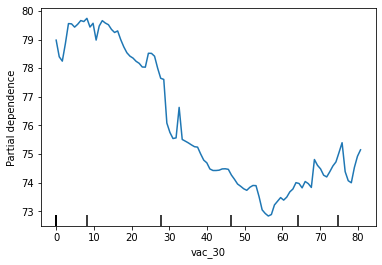

In [50]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rfm, X_val, ['vac_30'], centered=False)

In [51]:
perm = PermutationImportance(rfm, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.8608 ± 0.0856,new_cases_per_million
0.4475 ± 0.0156,USA
0.2750 ± 0.0228,IND
0.2424 ± 0.0292,si_14
0.2012 ± 0.0264,FRA
0.2006 ± 0.0263,BRA
0.1288 ± 0.0214,days_covid
0.1013 ± 0.0284,DEU
0.0682 ± 0.0060,2021
0.0606 ± 0.0065,UKR


In [52]:
# MAE on all, Random Forest

y_pred = rfm.predict(X_val)
y_pred[y_pred<0] = 0
mae = median_absolute_error(y_val, y_pred)
string_score = f"MAE on dataset: {mae:.2f}"
print (string_score)

MAE on dataset: 1.88


In [53]:
y_pred = rfm.predict(X_val.loc[idx,:])
y_pred[y_pred<0] = 0
mae = median_absolute_error(y_val.loc[idx], y_pred)
string_score = f"MAE on USA: {mae:.2f}"
print (string_score)

MAE on USA: 130.00


In [54]:
print(rfm.score(X_val, y_val), '\n')

# from sklearn.inspection import permutation_importance
# r = permutation_importance(rfm, X_val, y_val,\
#                             n_repeats=30, \
#                             random_state=0)

# for j,i in enumerate(r.importances_mean.argsort()[::-1]):
#     if j == 10:
#         break
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X_val.columns.to_list()[i]:<8}" \
#                 f"{r.importances_mean[i]:.3f}" \
#                 f" +/- {r.importances_std[i]:.3f}")

0.9161555143677489 



In [54]:
# # RandomForest

# from sklearn.inspection import PartialDependenceDisplay
# from time import time

# print("Computing partial dependence plots...")
# tic = time()

# fig, ax = plt.subplots(figsize=(20,20))

# ax.set_title(
#     "Partial dependence of deaths on features\n"
#     "for OWID dataset, with RF")


# display = PartialDependenceDisplay.from_estimator(
#     rfm,
#     X_val,
#     features=['vac_30'],
#     ax=ax, line_kw={"color": "blue"},
#     ice_lines_kw={"color": "orange"},
#     kind='average',
# #    subsample=50,
#     random_state=10,
# )
# print(f"done in {time() - tic:.3f}s")

In [55]:
usa = pd.DataFrame(X_val.loc[idx, 'days_covid'])
usa['true'] = y_val.values[idx]
usa['pred'] = y_pred

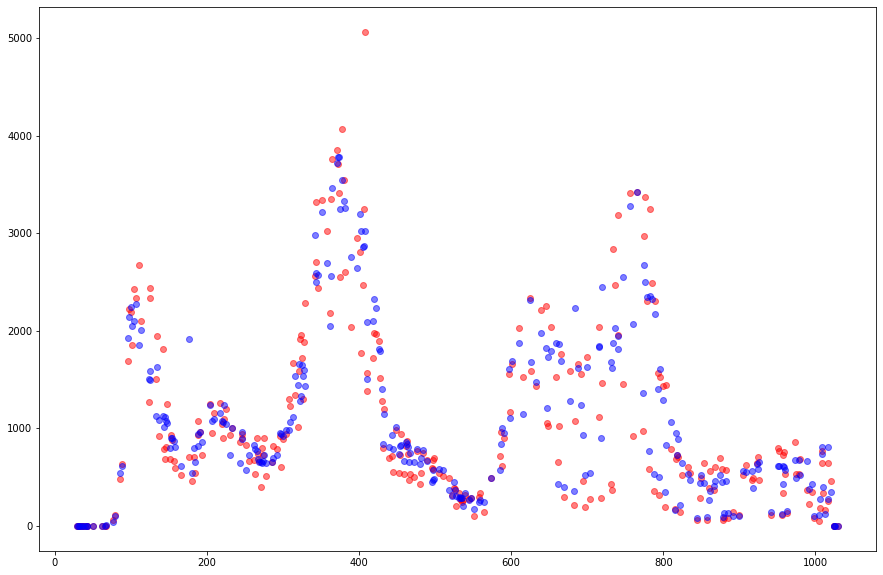

In [56]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=usa['days_covid'], y=usa['true'], alpha=0.5, c='red')
plt.scatter(x=usa['days_covid'], y=usa['pred'], alpha=0.5, c='blue')

plt.show()

In [57]:
# 100 obs for the USA (random since train_test_split shuffles randomly)

data_for_prediction = X_val[idx].iloc[100:200]

# data_for_prediction.columns

In [58]:
data_for_prediction[['2020', '2021', '2022', 'vax_period', 'days_covid',
       'new_cases_per_million', 'vac_30', 'si_14']].describe()

,vax_period,days_covid,new_cases_per_million,vac_30,si_14
count,100.00,100.000000,100.000000,100.00000,100.000000
mean,0.55,471.920000,245.873190,31.19190,52.607000
std,0.50,302.668124,319.869907,34.56862,20.671085
min,0.00,30.000000,0.000000,0.00000,0.000000
25%,0.00,206.250000,84.125750,0.00000,38.310000
50%,1.00,413.500000,164.026500,6.17500,58.800000
75%,1.00,754.000000,310.315750,73.13000,68.980000
max,1.00,1025.000000,2862.826000,79.54000,75.460000


In [59]:
import shap  # package used to calculate Shap values

In [60]:
shap.__version__

'0.43.0'

In [ ]:
# X100 = shap.utils.sample(data_for_prediction, 100)
# X100

In [61]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfm)

In [62]:
shap_values = explainer(data_for_prediction)

In [ ]:
# shap_values = explainer.shap_values(data_for_prediction, check_additivity=False)

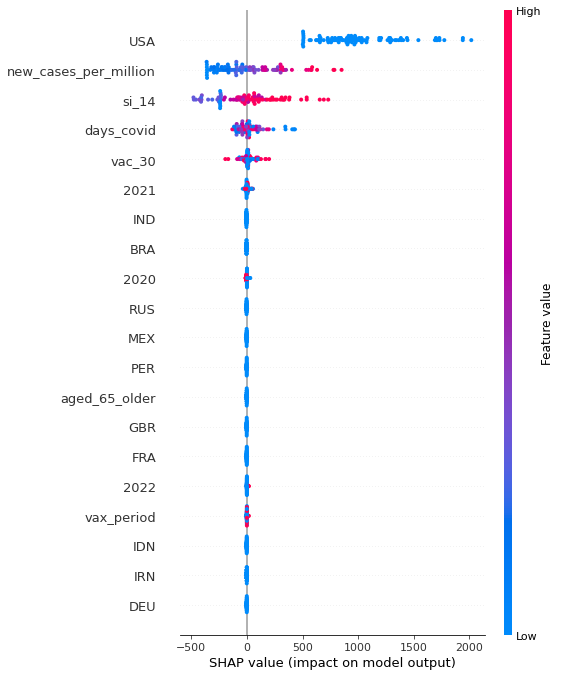

In [63]:
shap.initjs()

# Make plot. 
shap.summary_plot(shap_values, data_for_prediction)

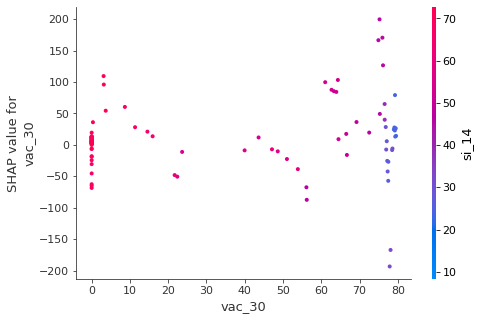

In [65]:
shap.dependence_plot(
    "vac_30", shap_values.values, data_for_prediction, interaction_index="si_14"
)

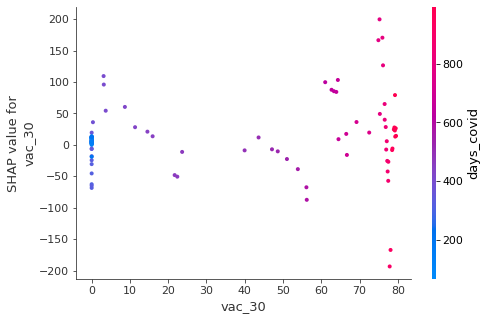

In [87]:
shap.dependence_plot(
    "vac_30", shap_values.values, data_for_prediction)

In [67]:
X

,AFG,ALB,ARG,ARM,AUT,AZE,BEL,BGD,BGR,BIH,...,ZAF,2020,2021,2022,vax_period,days_covid,si_14,new_cases_per_million,vac_30,aged_65_older
30,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,0,30,0.00,0.000,0.00,2.581
31,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,0,31,0.00,0.000,0.00,2.581
32,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,0,32,0.00,0.000,0.00,2.581
33,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,0,33,0.00,0.000,0.00,2.581
34,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,0,34,0.00,0.000,0.00,2.581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338735,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,1,1028,13.89,1.731,78.29,6.614
338736,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,1,1029,13.89,1.873,78.29,6.614
338737,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,1,1030,13.89,2.085,78.29,6.614
338738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,1,1031,13.89,0.919,78.29,6.614


In [68]:
with pd.option_context('display.max_rows', 500):
    display(data_for_prediction.iloc[20].loc[data_for_prediction.iloc[20] > 0])

USA                         True
2021                        True
vax_period                     1
days_covid                   403
si_14                      71.76
new_cases_per_million    274.708
vac_30                      3.17
aged_65_older             15.413
Name: 328451, dtype: object

In [69]:
sample_ind = 20

In [70]:
shap_values[20].shape

(92,)

In [71]:
_predicts = rfm.predict(X_train)

In [72]:
_predicts

array([ 0.  , 24.18,  2.77, ...,  0.  , 18.88,  0.  ])

In [73]:
_predicts.mean()

76.10250386398764

In [74]:
explainer.expected_value

array([76.0571571])

In [75]:
rfm.predict(data_for_prediction.iloc[20].values.reshape(1,-1))

array([3024.36])

In [79]:
shap_values

.values =
array([[-1.10137953e-02,  3.35248416e-03, -1.69445629e+00, ...,
        -5.33457202e+01,  4.93861579e+00, -3.20358247e+00],
       [-5.86793167e-02,  7.28664530e-03, -3.08178088e-01, ...,
        -2.48767335e+02,  3.99702705e+01, -2.93530539e-01],
       [-1.03402864e-02,  8.47466595e-03, -5.25075513e-01, ...,
         5.43046321e+01,  2.45154956e+01, -1.38277297e+00],
       ...,
       [-1.08602478e-02,  3.11438450e-03, -1.71448441e+00, ...,
        -1.87256331e-01,  1.26149122e+01, -3.01393726e+00],
       [-1.10391361e-02,  2.93786512e-03, -1.67363145e+00, ...,
        -5.48967922e+00,  8.53477101e+00, -3.24067375e+00],
       [-1.06145759e-02,  5.86685750e-03, -3.80796669e-01, ...,
        -9.11705974e+01, -2.69360389e+01, -1.00236698e+00]])

.base_values =
array([76.0571571, 76.0571571, 76.0571571, 76.0571571, 76.0571571,
       76.0571571, 76.0571571, 76.0571571, 76.0571571, 76.0571571,
       76.0571571, 76.0571571, 76.0571571, 76.0571571, 76.0571571,
       76.057157

In [80]:
shap.force_plot(explainer.expected_value[0], shap_values.values[sample_ind], data_for_prediction.iloc[sample_ind])

In [81]:
shap.force_plot(explainer.expected_value[0], shap_values.values[99], data_for_prediction.iloc[99])

In [83]:
shap.force_plot(explainer.expected_value[0], shap_values.values[0], data_for_prediction.iloc[0])

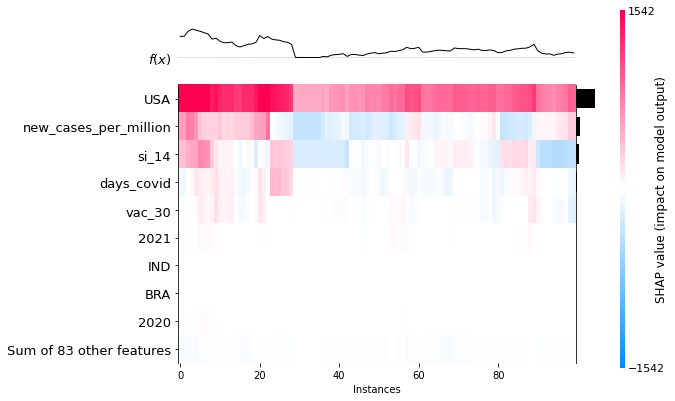

In [82]:
shap.plots.heatmap(shap_values)

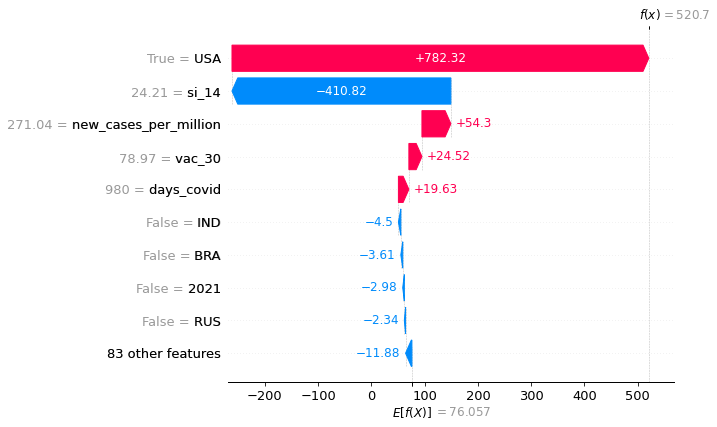

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

shap.plots.waterfall(shap_values[2])

# from shap.plots import _waterfall
# _waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[sample_ind], data_for_prediction.iloc[sample_ind])

In [88]:
# Random 100 obs

data_for_prediction = X_val.sample(100, random_state = 1)

data_for_prediction[['2020','2021','2022','vax_period','days_covid',
                     'new_cases_per_million','vac_30','aged_65_older', 'si_14']].describe()

,vax_period,days_covid,new_cases_per_million,vac_30,aged_65_older,si_14
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,0.580000,511.380000,190.364430,23.243400,11.415900,52.17090
std,0.496045,261.938646,850.839824,28.679536,6.816371,22.05544
min,0.000000,51.000000,0.000000,0.000000,2.355000,2.78000
25%,0.000000,270.750000,1.519500,0.000000,5.659000,38.80000
50%,1.000000,510.000000,19.501500,5.100000,8.533000,55.10500
75%,1.000000,713.000000,114.345250,46.057500,18.517000,69.44000
max,1.000000,997.000000,8249.080000,88.840000,27.049000,96.30000


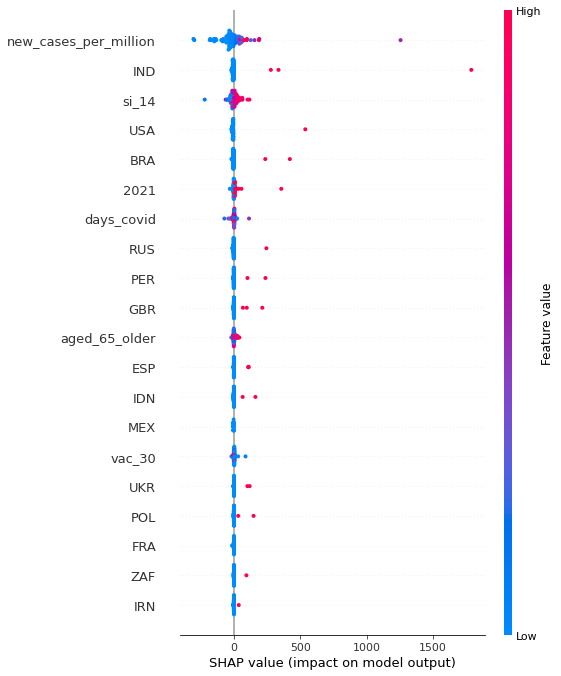

In [89]:
# Calculate shap_values for all of X_val 
shap_values = explainer(data_for_prediction)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, data_for_prediction)

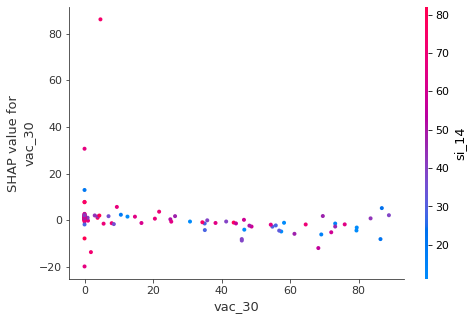

In [90]:
shap.dependence_plot(
    "vac_30", shap_values.values, data_for_prediction, interaction_index="si_14"
)

In [105]:
for i, col in enumerate(data_for_prediction.columns):
    if col == 'vac_30':
        print(i)        

90


In [106]:
(shap_values.values > 50)[:,90]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [107]:
shap_values.values[99,90]

86.1065822007393

In [109]:
data_for_prediction.iloc[99]

AFG                        False
ALB                        False
ARG                        False
ARM                        False
AUT                        False
                          ...   
days_covid                   486
si_14                      73.61
new_cases_per_million    259.776
vac_30                      4.64
aged_65_older              5.989
Name: 139648, Length: 92, dtype: object

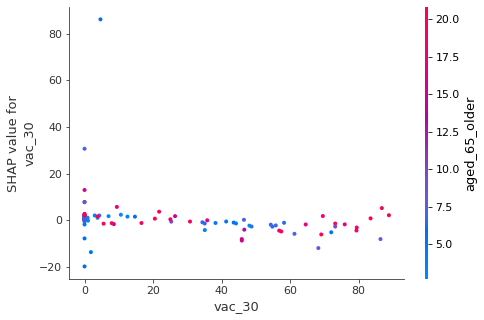

In [91]:
shap.dependence_plot(
    "vac_30", shap_values.values, data_for_prediction
)

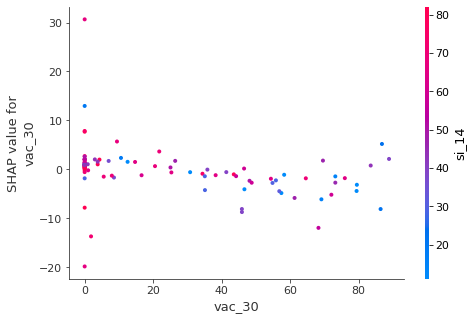

In [111]:
shap.dependence_plot(
    "vac_30", shap_values.values[:99], data_for_prediction.iloc[:99], interaction_index="si_14"
)

In [ ]:
for country in list(country_dummies.columns):
    if country not in data_for_prediction.columns:
        continue
    if data_for_prediction[country].sum() == 0:
        continue
    print(country, data_for_prediction[country].mean())

In [ ]:
print(list(X.columns).index('RUS'))
ISO_CHOSEN = list(X.columns).index('RUS')

In [ ]:
idx = X_val.iloc[:,ISO_CHOSEN] == 1

In [ ]:
data_for_prediction = X_val[idx].iloc[100:200]

data_for_prediction.columns

In [ ]:
data_for_prediction[['2020', '2021', '2022', 'vax_period', 'days_covid',
       'new_cases_per_million', 'vac_30', 'si_14']].describe()

In [ ]:
import shap  # package used to calculate Shap values

shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfm)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(data_for_prediction, check_additivity=False)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, data_for_prediction)

In [ ]:
y_pred = rfm.predict(X_val.loc[idx,:])
y_pred[y_pred<0] = 0

In [ ]:
rus = pd.DataFrame(X_val.loc[idx, 'days_covid'])
rus['true'] = y_val.values[idx]
rus['pred'] = y_pred

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=rus['days_covid'], y=rus['true'], alpha=0.5, c='red')
plt.scatter(x=rus['days_covid'], y=rus['pred'], alpha=0.5, c='blue')

plt.show()

In [ ]:
mae = median_absolute_error(rus['true'], rus['pred'])
string_score = f"MAE on RUS: {mae:.2f}"
print (string_score)

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
for i,col in enumerate(X_train.columns):
    print (i, col)

In [ ]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=[one for one in range(87)])
test_pool = Pool(X_val,
                 y_val,
                 cat_features=[one for one in range(87)]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=20000, 
                          depth=2, 
                          learning_rate=.8,
                          random_seed=1,
                          loss_function='RMSE',
                          verbose=200,    
                          eval_metric='MAE',
                          use_best_model=True
                         )
#train the model
model.fit(X_train, y=y_train, cat_features=[one for one in range(87)], eval_set=test_pool)
# make the prediction using the resulting model
# preds = model.predict(test_pool)
# print(preds)

In [ ]:
model.get_feature_importance(prettified=True)[:10]

In [ ]:
test_pool = Pool(X_val, 
                 cat_features=[one for one in range(87)]) 

# y_pred = model.predict(test_pool)

# y_pred[y_pred<0] = 0

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(test_pool)

shap.initjs()
shap.summary_plot(shap_values, X_val)

In [ ]:
shap_values = explainer.shap_values(X_val)
shap.dependence_plot('vac_30', shap_values, X_val)

In [ ]:
ISO_CHOSEN = list(X.columns).index('RUS')

idx = X_val.iloc[:,ISO_CHOSEN] == 1

test_pool = Pool(X_val[idx], 
                 cat_features=[one for one in range(87)]) 

y_pred = model.predict(test_pool)

y_pred[y_pred<0] = 0

In [ ]:
mae = median_absolute_error(y_val.loc[idx], y_pred)
string_score = f"MAE on RUS: {mae:.2f}"
print (string_score)

In [ ]:
rus = pd.DataFrame(X_val.loc[idx, 'days_covid'])
rus['true'] = y_val.values[idx]
rus['pred'] = y_pred

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=rus['days_covid'], y=rus['true'], alpha=0.5, c='red')
plt.scatter(x=rus['days_covid'], y=rus['pred'], alpha=0.5, c='blue')

plt.show()

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(test_pool)

shap.initjs()
shap.summary_plot(shap_values, X_val[idx])

In [ ]:
# shap_values = explainer.shap_values(X_val)
shap.dependence_plot('vac_30', shap_values, X_val[idx])

In [ ]:
ISO_CHOSEN = list(X.columns).index('USA')
idx = X_val.iloc[:,ISO_CHOSEN] == 1

In [ ]:
usa = pd.DataFrame(X_val.loc[idx, 'days_covid'])
usa['true'] = y_val.values[idx]
test_pool = Pool(X_val[idx], 
                 cat_features=[one for one in range(87)]) 
y_pred = model.predict(test_pool)
y_pred[y_pred<0] = 0
usa['pred'] = y_pred 

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=usa['days_covid'], y=usa['true'], alpha=0.5, c='red')
plt.scatter(x=usa['days_covid'], y=usa['pred'], alpha=0.5, c='blue')

plt.show()

In [ ]:
mae = median_absolute_error(y_val.loc[idx], y_pred)
string_score = f"MAE on USA: {mae:.2f}"
print (string_score)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(test_pool)

shap.initjs()
shap.summary_plot(shap_values, X_val[idx])

In [ ]:
shap.dependence_plot('vac_30', shap_values, X_val[idx])

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import tree

my_tree = tree.DecisionTreeRegressor(random_state=0)
my_tree.fit(X, y)


mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 100), \
                 tol=1e-2, max_iter=500, random_state=0),
)
mlp.fit(X_train, y_train)

In [ ]:
# MAE for MLP 

y_pred = mlp.predict(X_val)
y_pred[y_pred<0] = 0
mae = median_absolute_error(y_val.values, y_pred)
string_score = f"MAE on dataset: {mae:.2f}"
print (string_score)

In [ ]:
y_pred = mlp.predict(X_val[idx])
y_pred[y_pred<0] = 0

In [ ]:
usa = pd.DataFrame(X_val.loc[idx, 'days_covid'])
usa['true'] = y_val.values[idx]
usa['pred'] = y_pred

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10))

plt.scatter(x=usa['days_covid'], y=usa['true'], alpha=0.5, c='red')
plt.scatter(x=usa['days_covid'], y=usa['pred'], alpha=0.5, c='blue')

plt.show()

In [ ]:
perm2 = PermutationImportance(my_tree, random_state=1).fit(X, y)
eli5.show_weights(perm2, feature_names = X.columns.tolist())

In [ ]:
perm3 = PermutationImportance(mlp, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm3, feature_names = X.columns.tolist())

In [ ]:
imp_voc = dict()

for var, imp in zip(X.columns,my_tree.feature_importances_):
    imp_voc[var] = round(imp, 4)

In [ ]:
#Most important

sorted(imp_voc.items(), key=lambda item: item[1], reverse=True)[:20]

In [ ]:
plt.figure(figsize=(15,10))
tree.plot_tree(my_tree, max_depth=4, fontsize=10, feature_names=X.columns) 
plt.show()


In [ ]:
my_tree.get_depth()

In [ ]:
my_tree.get_n_leaves()

In [ ]:
names = ['vax_period', 'days_covid',
       'new_cases_per_million', 
       'vac_30']

In [ ]:
# Perfect Tree

from sklearn.inspection import PartialDependenceDisplay
from time import time

print("Computing partial dependence plots...")
tic = time()

fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title(
    "Partial dependence of deaths on features\n"
    "for OWID dataset, with Tree")


display = PartialDependenceDisplay.from_estimator(
    my_tree,
    X,
    features=names,
    ax=ax, 
    line_kw={"color": "red"},
    random_state=0
)

print(f"done in {time() - tic:.3f}s")



In [ ]:
# MLP

print("Computing partial dependence plots...")
tic = time()

fig, ax = plt.subplots(figsize=(20,20))

ax.set_title(
    "Partial dependence of deaths on features\n"
    "for OWID dataset, with MLP")


display = PartialDependenceDisplay.from_estimator(
    mlp,
    X,
    features=names,
    ax=ax, line_kw={"color": "blue"},
    ice_lines_kw={"color": "orange"},
    kind='average',
#    subsample=50,
    random_state=10,
)
print(f"done in {time() - tic:.3f}s")

In [ ]:
reg = make_pipeline(
    StandardScaler(),
    linear_model.Ridge(alpha=1, random_state=17),
)

reg.fit(X, y)

print("Computing partial dependence plots...")
tic = time()

fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title(
    "Partial dependence of deaths on features\n"
    "for OWID dataset, with Ridge")


display = PartialDependenceDisplay.from_estimator(
    reg,
    X,
    features=names,
    ax=ax, 
    line_kw={"color": "blue"},
    ice_lines_kw={"color": "orange"},
    kind='average',
#    subsample=50,
    random_state=10,
)
print(f"done in {time() - tic:.3f}s")

In [ ]:
# Excess Mortality

In [ ]:
data = covid_data_1K[
        country_1K +
        ['2020', '2021', '2022'] +
        [
        'vax_period',
        'days_covid',
        'v_days_covid',
#        'stringency_index',
#        'v_stringency',
        'new_cases_per_million',
        'v_new_cases_per_million',
#        'people_vaccinated_per_hundred',
        'vac_30',
#    'new_deaths',
    'excess_mortality'
]]